In [59]:
import pandas as pd
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [60]:
# yf.Tickers(['VIX', '^TYX']).history(period='5y')
yf.Ticker('F').info['pegRatio']

0.11

F
Bin Thresholds:  [-10, -0.1, 0.1, 10]


<AxesSubplot:>

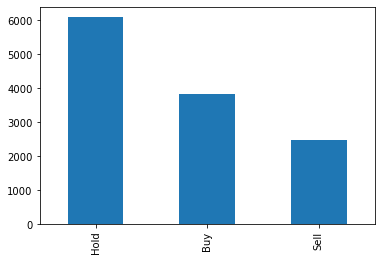

In [61]:
def generate_features(ticker, period_range="Max", buy_sell_threshold =[-0.1,0.1], gain_window = 60):
    stk_data = yf.Ticker(ticker)
    print(stk_data.ticker)
    df_data = stk_data.history(period=period_range)


    df_data['Week'] = df_data.index.isocalendar().week
    df_data['Day'] = df_data.index.isocalendar().day

    df_data['PrevDayChng'] = df_data['Close'].pct_change(periods=1).shift(1).fillna(0)
    df_data['Var'] = df_data.Close.rolling(10).var()
    df_data['Var'] = df_data['Var'].fillna(df_data['Var'].mean())

    df_data['52Wk_High'] = df_data.Close.rolling(260, min_periods=1).max()
    df_data['52Wk_Low'] = df_data.Close.rolling(260, min_periods=1).min()

    df_data['EMA5'] = df_data.Close.ewm(span=5, adjust=False).mean()
    df_data['EMA12'] = df_data.Close.ewm(span=12, adjust=False).mean()
    df_data['EMA26'] = df_data.Close.ewm(span=26, adjust=False).mean()
    df_data['MACD'] = df_data.EMA12-df_data.EMA26
    df_data['Signal'] = df_data.MACD.ewm(span=9, adjust=False).mean()
    df_data['MACD_Trigger'] = df_data.MACD - df_data.Signal

    # % Change in 2 weeks
    df_data['Short_Gain'] = df_data.Close.pct_change(10).shift(-10)
    df_data['Short_Gain'] = df_data['Short_Gain'].fillna(df_data['Short_Gain'].mean())

    # % change in long-term
    df_data['Long_Gain'] = df_data.Close.pct_change(gain_window).shift(-gain_window)
    df_data['Long_Gain'] = df_data['Long_Gain'].fillna(df_data['Long_Gain'].mean())

    bins=[-10]+buy_sell_threshold+[10]
    print("Bin Thresholds: ", bins)
    df_data['Rating'] = pd.cut(df_data.Long_Gain, bins=bins, labels=['Sell', 'Hold', 'Buy',])

    return df_data

df_data = generate_features('F')
df_data

df_data.Rating.value_counts().plot(kind='bar')


<AxesSubplot:xlabel='Date', ylabel='Close'>

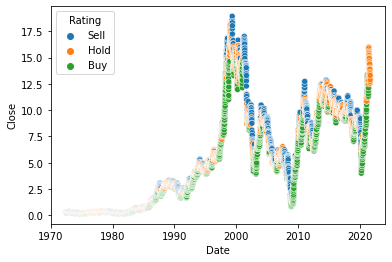

In [62]:
sns.scatterplot(data=df_data, x=df_data.index, y='Close', hue='Rating')

In [63]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12419 entries, 1972-06-01 to 2021-08-27
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Open          12419 non-null  float64 
 1   High          12419 non-null  float64 
 2   Low           12419 non-null  float64 
 3   Close         12419 non-null  float64 
 4   Volume        12419 non-null  int64   
 5   Dividends     12419 non-null  float64 
 6   Stock Splits  12419 non-null  float64 
 7   Week          12419 non-null  UInt32  
 8   Day           12419 non-null  UInt32  
 9   PrevDayChng   12419 non-null  float64 
 10  Var           12419 non-null  float64 
 11  52Wk_High     12419 non-null  float64 
 12  52Wk_Low      12419 non-null  float64 
 13  EMA5          12419 non-null  float64 
 14  EMA12         12419 non-null  float64 
 15  EMA26         12419 non-null  float64 
 16  MACD          12419 non-null  float64 
 17  Signal        12419 non-null  flo

In [64]:
def scale_data(df_data):
    price_scaler = MinMaxScaler()
    df_data_scaled = df_data
    df_data_scaled[['Close']] = price_scaler.fit_transform(df_data_scaled[['Close']])
    for c in ['Open', 'High', 'Low', '52Wk_High', '52Wk_Low']:
        df_data_scaled[[c]] = price_scaler.transform(df_data_scaled[[c]])

    indicator_cols =['Volume', 'Week', 'Day', 'PrevDayChng', 'MACD', 'Signal', 'EMA5', 'EMA12', 'EMA26', 'Var']
    indicator_scaler = MinMaxScaler()
    df_data_scaled[indicator_cols] = indicator_scaler.fit_transform(df_data_scaled[indicator_cols])

    # gain_cols = ['Short_Gain', 'Long_Gain']
    # gain_scaler = MinMaxScaler()
    # df_data_scaled[gain_cols] = gain_scaler.fit_transform(df_data_scaled[gain_cols])

    return df_data_scaled

df_data_scaled = scale_data(df_data)
df_data_scaled

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Week,Day,PrevDayChng,...,52Wk_Low,EMA5,EMA12,EMA26,MACD,Signal,MACD_Trigger,Short_Gain,Long_Gain,Rating
Date,,,,,,,,,,,,,,,,,,,,,
1972-06-01,-0.007552,0.007354,0.007187,0.007215,0.001465,0.0,0.0,0.403846,0.75,0.458563,...,0.007215,0.007098,0.007114,0.007041,0.507726,0.526226,0.000000,-0.013182,0.029565,Hold
1972-06-02,0.007215,0.007354,0.007131,0.007187,0.001619,0.0,0.0,0.403846,1.00,0.458563,...,0.007187,0.007088,0.007109,0.007038,0.507706,0.526222,-0.000033,-0.007546,0.031508,Hold
1972-06-05,0.007187,0.007326,0.007131,0.007187,0.009079,0.0,0.0,0.423077,0.00,0.455109,...,0.007187,0.007082,0.007106,0.007036,0.507690,0.526214,-0.000052,-0.013207,0.014348,Hold
1972-06-06,0.007187,0.007243,0.006964,0.007020,0.002080,0.0,0.0,0.423077,0.25,0.458563,...,0.007020,0.007020,0.007076,0.007022,0.507555,0.526177,-0.000261,0.001909,0.018249,Hold
1972-06-07,0.007020,0.007104,0.006937,0.006937,0.000695,0.0,0.0,0.423077,0.50,0.437798,...,0.006937,0.006951,0.007037,0.007001,0.507390,0.526108,-0.000478,-0.001920,0.045447,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,0.669006,0.676458,0.656230,0.670070,0.118834,0.0,0.0,0.634615,0.00,0.444086,...,0.338978,0.694214,0.723563,0.755411,0.331479,0.381413,-0.105183,0.005717,0.036800,Hold
2021-08-24,0.674329,0.691895,0.671667,0.688701,0.098680,0.0,0.0,0.634615,0.25,0.481911,...,0.338978,0.698361,0.722558,0.753422,0.339913,0.371353,-0.070418,0.005717,0.036800,Hold
2021-08-25,0.690830,0.699347,0.685507,0.693492,0.094100,0.0,0.0,0.634615,0.50,0.508994,...,0.338978,0.702765,0.722475,0.751956,0.351962,0.366106,-0.036723,0.005717,0.036800,Hold


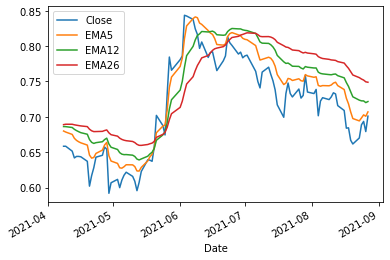

In [65]:
prices_sc = df_data_scaled.Close[-100:]
prices_sc.plot()
df_data_scaled.EMA5[-100:].plot()
df_data_scaled.EMA12[-100:].plot()
df_data_scaled.EMA26[-100:].plot()
plt.legend()

In [66]:
def part_data_train_test(df_data_scaled, test_size = 200):
    df_X_input = df_data_scaled.drop(columns=['Short_Gain', 'Long_Gain','Rating'])
    X_train = df_X_input[:-test_size].values
    X_test = df_X_input[-test_size:].values

    df_y_input = df_data_scaled['Long_Gain']
    y_train = df_y_input[:-test_size].values
    y_test = df_y_input[-test_size:].values

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = part_data_train_test(df_data_scaled)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12219, 19) (200, 19) (12219,) (200,)


In [98]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=10, random_state=1)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, random_state=1)

In [99]:
from sklearn.metrics import mean_absolute_error as mae

0.06740730963811077


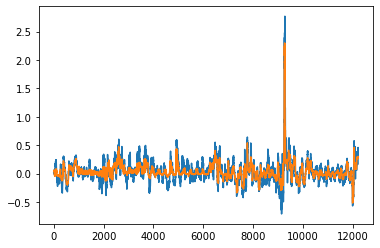

In [100]:
y_train_pred = model.predict(X_train)

sns.lineplot(x=np.arange(0,len(y_train)), y= y_train)
sns.lineplot(x=np.arange(0,len(y_train_pred)), y= y_train_pred)

print(mae(y_train, y_train_pred))

0.16783138165250727


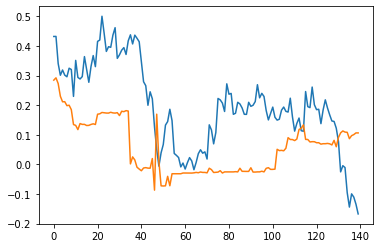

In [101]:
y_test_pred = model.predict(X_test[:len(X_test)-60])

sns.lineplot(x=np.arange(0,len(X_test)-60), y= y_test[:len(X_test)-60])
sns.lineplot(x=np.arange(0,len(y_test_pred)), y= y_test_pred)

print(mae(y_test[:len(X_test)-60], y_test_pred))

In [76]:
y_test_pred[-1]

-0.03906499520945529